# Elevation profile

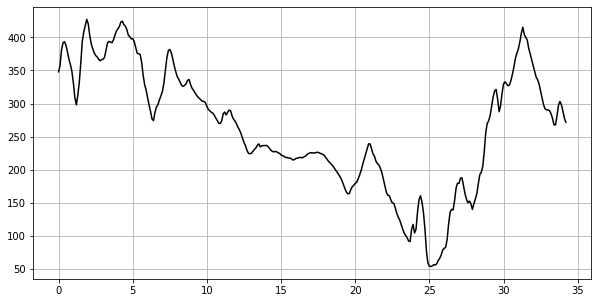

In [1]:
import matplotlib.pyplot as plt
from pycraf import pathprof
from astropy import units as u

pathprof.SrtmConf.set(srtm_dir='C:\SRTM', download='missing', server='viewpano')

# Tx and Rx points
lonTx, latTx = 6.8836 * u.deg, 50.525 * u.deg
lonRx, latRx = 7.3334 * u.deg, 50.635 * u.deg

# Profile granularity
hprof_step = 100 * u.m

(lons, lats, distance, distances,heights, bearing, back_bearing, back_bearings) = pathprof.srtm_height_profile (lonTx, latTx, lonRx, latRx, hprof_step)

_distances = distances.to(u.km).value
_heights = heights.to(u.m).value

plt.figure(figsize=(10,5))
plt.plot(_distances, _heights, '-k')
plt.grid()